# Chapter10 - LSTM FINAL

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [4]:
df = pd.read_csv("dataset_demand_forecasting_sd.csv")
df.head()

,Date,Sales
0,2014-01-01,11219
1,2014-01-02,12745
2,2014-01-03,10498
3,2014-01-04,12028
4,2014-01-05,13900


### Timeseries Based

In [5]:
df.head()

,Date,Sales
0,2014-01-01,11219
1,2014-01-02,12745
2,2014-01-03,10498
3,2014-01-04,12028
4,2014-01-05,13900


In [6]:
len(df)

2547

In [7]:
df['Sales'] = df["Sales"].rolling(window=20).mean()
df = df.dropna()

In [8]:
train = df[df["Date"]< '2018-01-01'].Sales.values.reshape(-1, 1)
test = df[df["Date"]>= '2018-01-01'].Sales.values.reshape(-1, 1)

In [9]:
train

array([[11956.6 ],
       [12030.3 ],
       [11959.45],
       ...,
       [50726.65],
       [51615.5 ],
       [53127.65]])

In [10]:
test

array([[ 53866.45],
       [ 54795.8 ],
       [ 56178.75],
       ...,
       [ 98101.  ],
       [ 99879.4 ],
       [100624.25]])

In [36]:
ds = df[["Sales"]].values

In [37]:
ds

array([[ 11956.6 ],
       [ 12030.3 ],
       [ 11959.45],
       ...,
       [ 98101.  ],
       [ 99879.4 ],
       [100624.25]])

In [38]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
ds = scaler.fit_transform(ds)

In [39]:
train_size = int(len(ds) * 0.75)
test_size = len(ds) - train_size
train, test = ds[0:train_size,:], ds[train_size:len(ds),:]
print(len(train), len(test))

1896 632


In [40]:
import numpy as np
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [41]:
look_back = 100
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [42]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [43]:
model = Sequential()
model.add(LSTM(2, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
1795/1795 - 2s - loss: 0.0028
Epoch 2/10
1795/1795 - 1s - loss: 8.1055e-04
Epoch 3/10
1795/1795 - 1s - loss: 5.6056e-04
Epoch 4/10
1795/1795 - 1s - loss: 5.1504e-04
Epoch 5/10
1795/1795 - 1s - loss: 4.0454e-04
Epoch 6/10
1795/1795 - 1s - loss: 3.8971e-04
Epoch 7/10
1795/1795 - 1s - loss: 3.6783e-04
Epoch 8/10
1795/1795 - 1s - loss: 3.3934e-04
Epoch 9/10
1795/1795 - 1s - loss: 3.3506e-04
Epoch 10/10
1795/1795 - 1s - loss: 3.3279e-04


In [44]:
trainY.ravel()

array([0.03902357, 0.03651177, 0.03368702, ..., 0.62340098, 0.62526851,
       0.62989645])

In [45]:
import math
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY.ravel()])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY.ravel()])


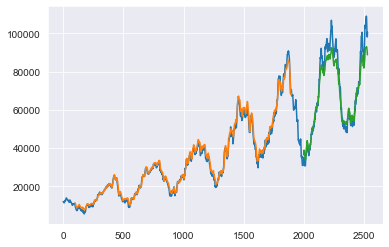

In [46]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()